# POI Data Analysis

## Import

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.xkcd()
!% config InlineBackend.figure_format = 'retina'
from scipy import stats

/bin/bash: line 0: fg: no job control


## Load Data
Here we load the datasets, we first specify the datasets path and root folders then we load the datasets. To do the analysis, we first load the check-ins record dataset then to have some specific analysis on different users groups we create different group of users based on their activity and check-in frequancy: `low active`, `medium active`, `high active`, `very high active`.

### Root data path

In [21]:
# dataset specification
data_dir = "../datasets/"
group_dir = "../groups"
# you can change the dataset name when you want to run it on different dataset
dataset_name = "Gowalla" # Yelp, Gowalla, or foursquare

### Load check-ins data

In [22]:
# read user checkins
cols = ['user', 'poi', 'timestamp']
user_events_file = data_dir + dataset_name + "/" + dataset_name + "_checkins.txt"
df_events = pd.read_csv(user_events_file, sep='\t', names=cols)
print('No. of users: ' + str(len(df_events.user.unique())))
print('No. of items: ' + str(len(df_events.poi.unique())))
print('No. of user events: ' + str(len(df_events)))

No. of users: 5628
No. of items: 30943
No. of user events: 618621


In [23]:
df_events.head()

,user,poi,timestamp
0,0,2049,1.287504e+09
1,0,0,1.287411e+09
2,0,1,1.287330e+09
3,0,328,1.287315e+09
4,0,14774,1.287226e+09


In [24]:
# create user-item matrix
predict_col = 'poi'
df_events = df_events.groupby(['user', predict_col]).size().reset_index(name='count')
print('No. user-item interactions: ' + str(len(df_events)))

No. user-item interactions: 377189


### Load user groups data

In [25]:
if dataset_name == 'Gowalla':
  user_groups = ['19', '47', '94', 'more']
elif dataset_name == 'Yelp':
  user_groups = ['51', '128', '256', 'more']

In [26]:
low_user_file = group_dir + "/users/" + dataset_name + '/users_checkins_' + user_groups[0] + '.txt'
medium_user_file = group_dir + "/users/" + dataset_name + '/users_checkins_' + user_groups[1] + '.txt'
high_user_file = group_dir + "/users/" + dataset_name + '/users_checkins_' + user_groups[2] + '.txt'
veryhigh_user_file = group_dir + "/users/" + dataset_name + '/users_checkins_' + user_groups[3] + '.txt'

## Data Statistics

In [27]:
item_threshold = 1 # 1 means no filtering
df_events = df_events[df_events['count'] >= item_threshold]
print('No. filtered user check-ins: ' + str(len(df_events)))
print('No. filtered items: ' + str(len(df_events[predict_col].unique())))

No. filtered user check-ins: 377189
No. filtered items: 30943


In [28]:
# get user distribution
user_dist = df_events['user'].value_counts()
num_users = len(user_dist)
print('Mean POIs per user: ' + str(user_dist.mean()))
print('Min POIs per user: ' + str(user_dist.min()))
print('Max POIs per user: ' + str(user_dist.max()))

Mean POIs per user: 67.02007818052594
Min POIs per user: 12
Max POIs per user: 969


In [29]:
# get item distribution
item_dist = df_events[predict_col].value_counts()
num_items = len(item_dist)
print('No. POIs: ' + str(num_items))

# Calculate "N" portion (N*100 percent) of data to be shown on the plot
portion = 0.2
seperatorPosition = df_events[predict_col].quantile(portion)
print(f'Index of {portion} of data (short-head): ' + str(seperatorPosition))
print(f'Percentage among total items: ', (seperatorPosition / num_items) * 100)

No. POIs: 30943
Index of 0.2 of data (short-head): 1914.0
Percentage among total items:  6.185567010309279


## Long-tail Anaylsis

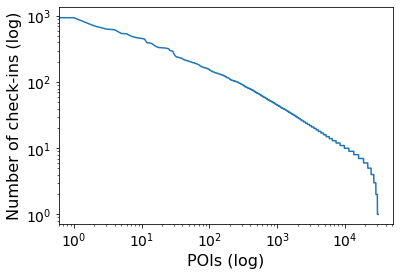

In [30]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.xlabel('POIs (log)', fontsize='16')
plt.ylabel('Number of check-ins (log)', fontsize='16')
plt.xscale('log')
plt.yscale('log')
plt.savefig('results/' + dataset_name + '/' + 'long-tail-log.pdf', dpi=300, bbox_inches='tight')

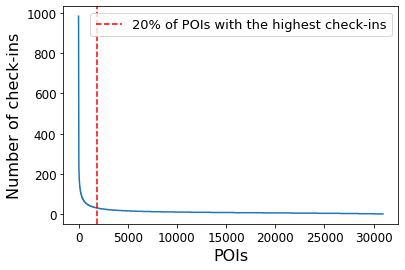

In [31]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
plt.xlabel('POIs', fontsize='16')
plt.ylabel('Number of check-ins', fontsize='16')
plt.axvline(x=seperatorPosition, color='red', linestyle='--', label='20% of POIs with the highest check-ins') # The vertical line
plt.legend(fontsize='13', loc = "upper right")
plt.savefig('results/' + dataset_name + '/' + 'long-tail-normal.pdf', dpi=300, bbox_inches='tight')

In [32]:
# get top items
top_fraction = 0.2
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 6188


In [33]:
# read users
low_users = pd.read_csv(low_user_file, sep=',', header=None)
medium_users = pd.read_csv(medium_user_file, sep=',', header=None)
high_users = pd.read_csv(high_user_file, sep=',', header=None)
veryhigh_users = pd.read_csv(veryhigh_user_file, sep=',', header=None)
no_users = len(low_users) + len(medium_users) + len(high_users) + len(veryhigh_users)
print(len(low_users), len(medium_users), len(high_users), len(veryhigh_users))
print('No. of users: ' + str(no_users))

921 1992 1266 1449
No. of users: 5628


In [34]:
# get pop fractions
pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_fraq = [] # relative number of top items per user
pop_item_fraq = [] # average popularity of items in user profiles

low_profile_size = 0
low_gap = 0

medium_profile_size = 0
medium_gap = 0

high_profile_size = 0
high_gap = 0
veryhigh_profile_size = 0
veryhigh_gap = 0

low_count = 0
med_count = 0
high_count = 0
veryhigh_count = 0

for u, df in df_events.groupby('user'):
    no_user_items = len(set(df[predict_col])) # profile size
    no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist.index)) # top items in profile
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq.append(no_user_pop_items / no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_fraq = sum(item_dist[df[predict_col]] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        low_count += 1
    elif u in medium_users.index:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        med_count += 1
    elif u in high_users.index:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
        high_count += 1
    else:
        veryhigh_profile_size += no_user_items
        veryhigh_gap += user_pop_item_fraq
        veryhigh_count += 1

low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)
veryhigh_profile_size /= len(veryhigh_users)

low_gap /= len(low_users)
medium_gap /= len(medium_users)
high_gap /= len(high_users)
veryhigh_gap /= len(veryhigh_users)

print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))
print('Very High count (for check): ' + str(veryhigh_count))

Low count (for check): 921
Med count (for check): 1071
High count (for check): 0
Very High count (for check): 3636


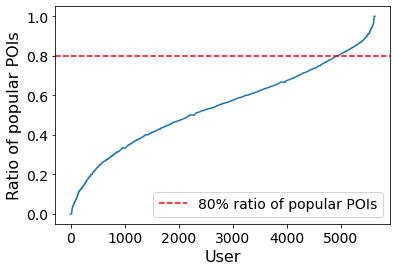

In [35]:
plt.figure()
plt.plot(sorted(pop_fraq))
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.xlabel('User', fontsize='16')
plt.ylabel('Ratio of popular POIs', fontsize='16')
plt.axhline(y=0.8, color='red', linestyle='--', label='80% ratio of popular POIs')
plt.legend(fontsize='14', loc = "lower right")
plt.savefig('results/' + dataset_name + '/' + 'user_poi_ratio.pdf', dpi=300, bbox_inches='tight')

R-value: 0.9319120756963359


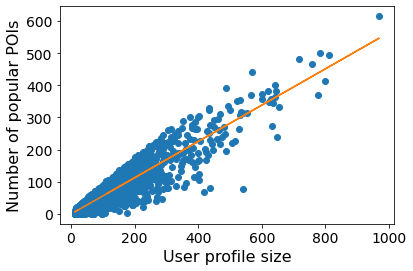

In [36]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_count)
print('R-value: ' + str(r_value))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_count, 'o', user_hist, line)
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.xlabel('User profile size', fontsize='16')
plt.ylabel('Number of popular POIs', fontsize='16')
plt.savefig('results/' + dataset_name + '/' + 'corr_user_numebr.pdf', dpi=300, bbox_inches='tight')

R-value: -0.0819801512722597
SpearmanrResult(correlation=0.03140434982107537, pvalue=0.01847232144153263)


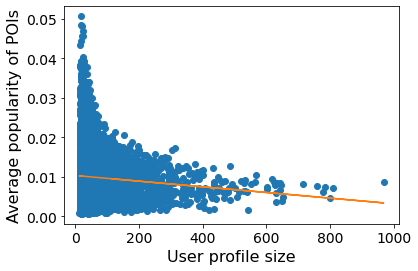

In [37]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_item_fraq)
print('R-value: ' + str(r_value))
print(stats.spearmanr(user_hist, pop_item_fraq))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_item_fraq, 'o', user_hist, line)
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.xlabel('User profile size', fontsize='16')
plt.ylabel('Average popularity of POIs', fontsize='16')
plt.savefig('results/' + dataset_name + '/' + 'corr_user_avg.pdf', dpi=300, bbox_inches='tight')

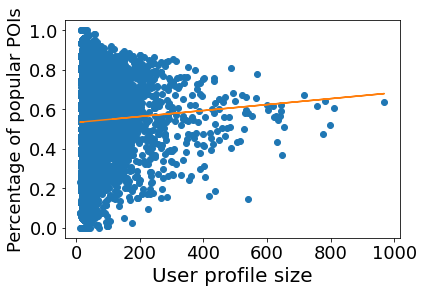

In [38]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_fraq)
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_fraq, 'o', user_hist, line)
plt.xticks(fontsize='18')
plt.yticks(fontsize='18')
plt.xlabel('User profile size', fontsize='20')
plt.ylabel('Percentage of popular POIs', fontsize='18')
plt.savefig('results/' + dataset_name + '/' + 'corr_user_prec.pdf', dpi=300, bbox_inches='tight')

3D Image for the intorduction

/var/folders/nb/mtr544q50k388rbnch13x9dm0000gn/T/ipykernel_12538/2378871106.py:27: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  env = figure.gca(projection='3d')


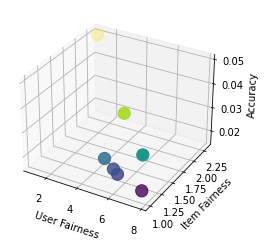

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

dataset_name = 'Gowalla'

colors = ["green", "orange", "gold", "blue", "yellow", "purple", "red", "magenta"]
colorMap = ListedColormap(colors)

# customLines = [Line2D([0], [0], color='red', lw=4),
#                Line2D([0], [0], color='blue', lw=4),
#                Line2D([0], [0], color='green', lw=4)]

if dataset_name == 'Gowalla':
    accuracy = [0.0247, 0.0231, 0.0166, 0.034, 0.0454, 0.0279, 0.0496]
    userFairness = [6.0141, 6.2659, 7.44, 7.7823, 6.3031, 5.4689, 1.0]
    itemFairness = [1.0, 1.0, 1.1108, 1.0024, 1.1244, 1.0, 2.3196]
    models = ['Mostpp', 'BPR', 'WMF', 'PF', 'VAECF', 'NeuMF', 'LORE']
elif dataset_name == 'Yelp':
    accuracy = [0.0097, 0.009, 0.0204, 0.0327, 0.0334, 0.0086, 0.0197, 0.0197]
    userFairness = [3.887, 3.962, 6.119, 3.241, 4.468, 3.943, 1.101, 1.148] 
    itemFairness = [1.0, 1.0, 1.245, 1.069, 1.031, 1.0, 3.096, 2.580]
    models = ['Mostpp', 'BPR', 'WMF', 'PF', 'VAECF', 'NeuMF', 'GeoSoCa', 'LORE']

figure = plt.figure()
env = figure.gca(projection='3d')

chart = env.scatter3D(userFairness, itemFairness, accuracy, s=150, c=accuracy, marker='o')
# env.legend(customLines, ['Cold', 'Medium', 'Hot'])

env.set_xlabel('User Fairness')
env.set_ylabel('Item Fairness')
env.set_zlabel('Accuracy')

plt.savefig('results/' + dataset_name + '/' + 'models_tradeoff.pdf', dpi=300, bbox_inches='tight')